In [17]:
#! /usr/bin/env python3

"""
- Notes about environment set up
    - returning (s,a,r,s') for the current step is key. Otherwise, Hole or Goal states will be zeros
- Notes about first visit MC:
    1. I see scenario where you get stuck in a state, during the state transition
        - We need an extra penalty for getting stuck. RL is too dumb to realize it itself, 
    2. In value iteration, you know the model. So, you can get an accurate estimate of value at each
    state. But here, you may not even get to the succeed state. 
    So, it's important to have penalty
    3. Monte Carlo Control may not converge.
        - History being reversed didn't seem to be a problem?
        - All ice melts in 100steps. But be careful, don't set that penalty too high
        - large initial epsilon and shrinking it seems to be beneficial
        - The more episodes, the better? Not necessarily. You want to make sure your penalty is set well.
            - Start with a minimal map, and see if you get stuck
        - I see oscillation: 
            1. the agent couldn't find a way to the goal using its current optimal path
            2. Then, until max_step is reached, it will give it lower penalty. That's a local maximum in the
                Q(s,a) world
            3. Epsilon-greedy could reinforce this oscillation, as exploration doesn't have enough data
            points to correct it
- About first Visit MC
    - Do not increment N before calculating V
    - Ideally, the value table should look like potential field. But the penalty for visiting the same state really takes that away
    - The value table may include oscillations.
- About TD:
    - Less variance in between episodes, but high bias
    
- General:
    - number of episodes to convergence: first visit MC with and without policy improvement: 500 vs 1500 vs 6000.  
"""

# Glossary
# P: nested dictionary
# 	From gym.core.Environment
# 	For each pair of states in [1, nS] and actions in [1, nA], P[state][action] is a
# 	tuple of the form (probability, nextstate, reward, terminal) where
# 		- probability: float
# 			the probability of transitioning from "state" to "nextstate" with "action"
# 		- nextstate: int
# 			denotes the state we transition to (in range [0, nS - 1])
# 		- reward: int
# 			either 0 or 1, the reward for transitioning from "state" to
# 			"nextstate" with "action"
# 		- terminal: bool
# 		  True when "nextstate" is a terminal state (hole or goal), False otherwise
# nS: int
# 	number of states in the environment
# nA: int
# 	number of actions in the environment
# gamma: float
# 	Discount factor. Number in range [0, 1)
# Returns: index of action
from frozen_lake_env import FrozenLakeEnv, MAPS
import numpy as np
import gym
import os
import time
from collections import deque, defaultdict
from typing import Tuple, Deque
import matplotlib.pyplot as plt

TOL = 0.001
RUNS_NUM = 10
EPISODE_NUM = 2000
IMPORTANCE_SAMPLING_RUNS_NUM = 10
GAMMA = 0.98
total_rewards = np.zeros((RUNS_NUM, EPISODE_NUM))

np.set_printoptions(precision=3)

#####################################################
# Tool Functions
#####################################################

def epsilon_greedy_policy(policy, state, nA, epsilon):
    """Generate a randomly distributed number. If it is less than epsilon, return a random action, 
    else return the action with the highest policy value
    nA is the number of actions
    """
    if np.random.uniform() < epsilon:
        return np.random.randint(nA)
    else:
        return policy[state]

def render_single(env, policy, state_output_file, max_steps=100):
    """
    env: gym.core.Environment - Environment to play on. Must have nS, nA, and P as attributes.
    Policy: np.array of shape [env.nS]. The action to take at a given state
    """ 
    episode_reward = 0
    ob = env.reset()
    try:
        os.remove(state_output_file)
    except FileNotFoundError:
        pass
    #TODO Remember to remove
    print(f'=========================Single Run========================')
    for t in range(max_steps):
        env.render(state_output_file)
        old_state = ob
        a = policy[ob]
        ob, rew, done, _ = env.step(a)
        episode_reward += rew
        if done:
            break
        #TODO Remember to remove
        print(f"state: {old_state}, action: {a}, reward: {rew}")
    env.render(state_output_file)
    if not done:
        print("The agent didn't reach a terminal state in {} steps.".format(max_steps))
    else:
        print("Episode reward: %f" % episode_reward)

def run_one_episode(env, policy, epsilon, state_output_file:str, max_steps:int=100) -> Deque[Tuple]:
    """

    Args:
        env: gym.core.Environment - Environment to play on. 
            Must have nS, nA, and P as attributes.
        Policy: np.array of shape [env.nS]. The action to take at a given state
            Here the policy is deterministic
        state_output_file (str): output file name
        max_steps (int, optional): maximum number of steps per episode. Defaults to 100.

    Returns:
        Deque[Tuple]: replay buffer with [(s, a, r, s')...]
    """
    
    episode_reward = 0
    current_state = env.reset()
    episodic_replay_buffer = deque()
    env.render(state_output_file)
    for t in range(max_steps):
        a = epsilon_greedy_policy(policy, current_state, env.nA, epsilon)
        current_state, rew, done, _ = env.step(a)
        episode_reward += rew
        env.render(state_output_file)
        # episodic_replay_buffer: [s, a, r]
        # we are appending to the beginning, so you don't have to revert it
        episodic_replay_buffer.appendleft((current_state, a, rew))
        if done:
            break
    env.render(state_output_file)
    return episodic_replay_buffer

def plot_rewards(total_rewards):
    """Plot rewards

    Args:
        total_rewards (list-like): 2D array: [run1[episode1 ...], run2[episode1 ...]...]
    """
    avg_rewards = np.mean(np.asarray(total_rewards), axis=0)
    plt.plot(range(EPISODE_NUM), avg_rewards)
    plt.show()

from tabulate import tabulate
def print_array_and_map_in_2D(map, array):
    map_str = "".join(map)
    row_num = len(map)
    tab_dict = {}
    row_start = ""
    for i, v in enumerate(array):
        tab_str = f"{map_str[i]} {round(v,2)}"
        if i % row_num == 0:
            tab_dict[tab_str] = []
            row_start = tab_str
        else:
            tab_dict[row_start].append(tab_str)
            
    print(tabulate(tab_dict, headers="keys", tablefmt='fancy_grid', missingval='N/A'))

def show_V_history(V_history, title):
    """
    Plotting all V
    Call this function for every-visit and TD algorithms

    Args:
        V_history (ndarray): np.zeros((EPISODE_NUM, env.nS))
    """
    V_history = np.asarray(V_history)
    V_history_T = np.transpose(V_history)
    for i, V in enumerate(V_history_T):
        plt.plot(np.arange(V_history.shape[0]), V, label=f"state {i}")
    plt.legend(loc=1, fontsize = 'x-small')
    plt.title(title)
    plt.show()

def update_v_history(v_history: deque, Q_sa:np.ndarray):
    v = np.zeros(env.nS)
    for s, q_s in enumerate(Q_sa):
        v[s] = max(q_s)
    v_history.append(v)

## MC Algorithms

In [2]:

#####################################################
# Business Logic
#####################################################

def first_visit_mc(env):
    for run_i in range(RUNS_NUM):
        policy = np.zeros(env.nS, dtype=int)
        N = 1
        # 2D array: column is each action, row is each state
        Q_function = np.zeros((env.nS, env.nA))
        # history of G value of Q
        GQ = np.zeros((env.nS, env.nA))
        epsilon = 0.6
        for episode_i in range(EPISODE_NUM):
            # This is equivalent to policy evaluation in MDP. We are learning the value function!
            # Also, we use the updated policy immediately
            episodic_replay_buffer = run_one_episode(env, policy, epsilon, "first_visit_mc.tmp", 100)
            # After one episode, update GQ: GQ = G+gamma * GQ[-1]
            # this is a trick we use: append a zero that we don't care
            gamma_rewards_history = deque([0])
            undiscounted_total_reward = 0
            for transition in episodic_replay_buffer:
                s, a, r = transition
                gamma_reward = r + GAMMA * gamma_rewards_history[-1]
                gamma_rewards_history.append(gamma_reward)
                GQ[s][a] = gamma_reward
                undiscounted_total_reward += r
            N += 1
            # # Update Q: 
            # new_Q_function = Q_function + 1/N * (GQ-Q_function)
            # Q_function = new_Q_function
            # policy = np.argmax(Q_function, axis=1)
            # epsilon *= 0.995
            
            total_rewards[run_i][episode_i] = undiscounted_total_reward
    print(f'Q_function: {Q_function}')
    print(f'policy: {policy}')
    return Q_function, policy

def evaluate_policy_importance_sampling(target_policy, env):
    # behavior is totally random
    behavior_epsilon = 1.0
    behavior_probability = behavior_epsilon/env.nA
    # Oh man, it's technically zero since we like determinstic policy in real life
    target_epislon = 0.2
    print(f'target policy: {target_policy}')
    V_all = []
    for run_i in range(IMPORTANCE_SAMPLING_RUNS_NUM):
        V = np.zeros(env.nS)
        # values of s1 across EPISODE_NUM
        V_s1_history = []
        for episode_i in range(EPISODE_NUM):
            episodic_replay_buffer = run_one_episode(env, policy, behavior_epsilon, 
                                                    "first_visit_mc.tmp", 100)
            episodic_target_G = np.zeros((env.nS, env.nA))
            G = 0
            weight = 1
            for e_pair in episodic_replay_buffer:
                s, a, r = e_pair
                G = (r + GAMMA * G)
                target_probability = target_epislon/env.nA +\
                    (1-target_epislon)*(target_policy[s] == a)

                weight *= (target_probability/behavior_probability)
                episodic_target_G[s][a] = weight * G
            # V(s) = mean of weighted G
            V += np.sum(episodic_target_G, axis=1)
            V_tmp = V/(episode_i + 1)
            V_s1_history.append(V_tmp[0])
        V_all.append(V_s1_history)
    print(f'V_all after importance sampling: {V_all}')
    return V_all

# first visit mc
env = FrozenLakeEnv(map_name="4x4", is_slippery=False)
Q_function, policy = first_visit_mc(env)
V_all = evaluate_policy_importance_sampling(policy, env)
plot_rewards(V_all)
# render_single(env, policy, "2_frozen_lake_monte_carlo.tmp", 100)

NameError: name 'FrozenLakeEnv' is not defined

In [ ]:
EPISODE_NUM = 10000
MAP = "4x4"
env = FrozenLakeEnv(map_name=MAP, is_slippery=False) 
policy = np.zeros(env.nS) 
V_history = np.zeros((EPISODE_NUM, env.nS))
total_G = np.zeros(env.nS)
# N starts from 1
Ns = np.zeros(env.nS)
episodic_replay_buffer = None
def every_visit_mc(env):
    """
    We are using a uniformly distributed random policy
    """
    for i in range(EPISODE_NUM):
        G = 0.0
        # epsilon = 1.0
        episodic_replay_buffer = run_one_episode(env, policy, 1.0, "first_visit_mc.tmp", 100)
        for transition in episodic_replay_buffer:
            s, a, r= transition
            Ns[s] = Ns[s] + 1
            G = r + GAMMA * G
            # every time we visit s, update with 1/N
            total_G[s] += G
        # Yeah there'll be NaN. 
        V_history[i] = total_G/Ns

    return V_history
    
# every visit mc
V_history = every_visit_mc(env)
print_array_and_map_in_2D(MAPS[MAP], V_history[-1])
show_V_history(V_history, every_visit_mc)

## TD Algorithms

In [65]:
EPISODE_NUM = 10000
# EPISODE_NUM = 10
MAP = "4x4"
env = FrozenLakeEnv(map_name=MAP, is_slippery=False) 
policy = np.zeros(env.nS) 
V = np.zeros(env.nS)
V_history = np.zeros((EPISODE_NUM, env.nS))
total_G = np.zeros(env.nS)
# N starts from 1
Ns = np.zeros(env.nS)
episodic_replay_buffer = None
state_output_file = "first_visit_mc.tmp"
ALPHA = 0.01

def get_reverse_ls_from_second_last_element(ls):
    if len(ls) < 2:
        return []
    return list(ls)[-2::-1]

def run_td(max_steps, env, epsilon, td_num = 0, adaptive_alpha = False):
    current_state = env.reset()
    buffer_start_state = current_state
    env.render(state_output_file)
    td_replay_buffer = deque()
    for t in range(max_steps):
        while len(td_replay_buffer) < td_num+1:
            a = epsilon_greedy_policy(policy, buffer_start_state, env.nA, epsilon)
            buffer_start_state, r, done, _ = env.step(a)
            td_replay_buffer.append((buffer_start_state, a, r, done))
            env.render(state_output_file)
        # TD_target = r1 + yr2 + ... y^nV[s^n]
        td_target = td_replay_buffer[-1][2] + GAMMA * V[td_replay_buffer[-1][0]]
        for replay_buffer in get_reverse_ls_from_second_last_element(td_replay_buffer):
            s, _, r, _ = replay_buffer
            td_target = r + GAMMA * td_target
        if adaptive_alpha:
            Ns[current_state] += 1
            alpha = 1/Ns[current_state] 
        else:
            alpha = ALPHA
        V[current_state] = (1-alpha) * V[current_state] + alpha * td_target
        s_prime, a, r, done = td_replay_buffer.popleft()
        # #TODO Remember to remove
        # print(f'Rico: td_target: {td_target}, current_state: {current_state}, prime {s_prime}')
        current_state = s_prime
        if len(td_replay_buffer) > 0:
            # Update state all the way until the next state is done
            done = td_replay_buffer[0][3]
        if done:
            break
    env.render(state_output_file)

╒════════════╤═══════════╤═══════════╤══════════╕
│ S -85.09   │ F -88.8   │ F -88.4   │ H 0.0    │
╞════════════╪═══════════╪═══════════╪══════════╡
│ F -88.8    │ H 0.0     │ F -76.28  │ F -53.66 │
├────────────┼───────────┼───────────┼──────────┤
│ F -86.32   │ F -86.26  │ F -69.31  │ F -4.81  │
├────────────┼───────────┼───────────┼──────────┤
│ F -90.37   │ H 0.0     │ H 0.0     │ G 0.0    │
╘════════════╧═══════════╧═══════════╧══════════╛


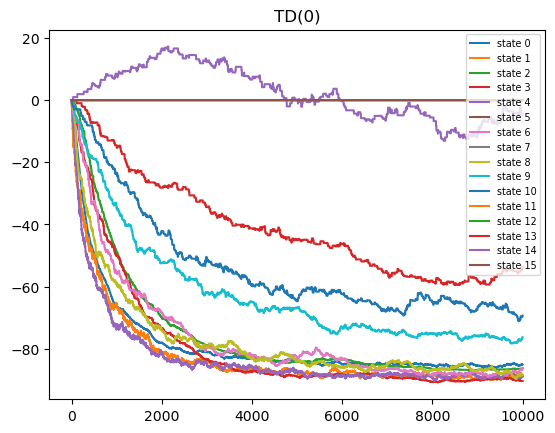

In [57]:
td_num = 0
for i in range(EPISODE_NUM):
    run_td(max_steps=100, env=env, epsilon=1.0, td_num=td_num)
    V_history[i] = V.copy()
       
print_array_and_map_in_2D(MAPS[MAP], V_history[-1])        
show_V_history(V_history, f"TD({td_num})")


╒════════════╤════════════╤════════════╤══════════╕
│ S -77.18   │ F -76.54   │ F -74.67   │ H 0.0    │
╞════════════╪════════════╪════════════╪══════════╡
│ F -75.7    │ H 0.0      │ F -66.98   │ F -39.73 │
├────────────┼────────────┼────────────┼──────────┤
│ F -76.69   │ F -68.53   │ F -56.14   │ F -43.65 │
├────────────┼────────────┼────────────┼──────────┤
│ F -76.6    │ H 0.0      │ H 0.0      │ G 0.0    │
╘════════════╧════════════╧════════════╧══════════╛


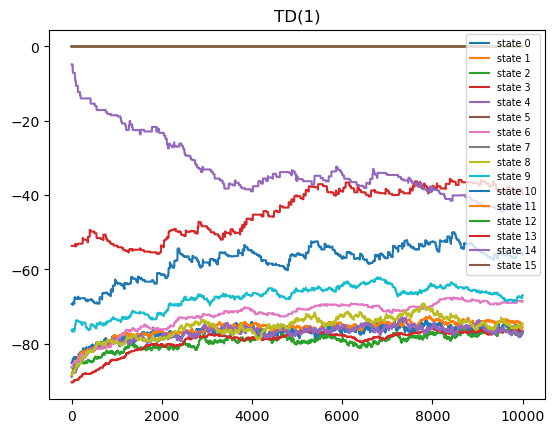

In [58]:
td_num = 1
for i in range(EPISODE_NUM):
    run_td(max_steps=100, env=env, epsilon=1.0, td_num=td_num)
    V_history[i] = V.copy()
       
print_array_and_map_in_2D(MAPS[MAP], V_history[-1])        
show_V_history(V_history, f"TD({td_num})")


╒═════════════╤═════════════╤═════════════╤═══════════╕
│ S -196.93   │ F -221.47   │ F -284.99   │ H 0.0     │
╞═════════════╪═════════════╪═════════════╪═══════════╡
│ F -251.63   │ H 0.0       │ F -347.43   │ F -420.38 │
├─────────────┼─────────────┼─────────────┼───────────┤
│ F -350.33   │ F -390.64   │ F -395.67   │ F -444.01 │
├─────────────┼─────────────┼─────────────┼───────────┤
│ F -368.17   │ H 0.0       │ H 0.0       │ G 0.0     │
╘═════════════╧═════════════╧═════════════╧═══════════╛


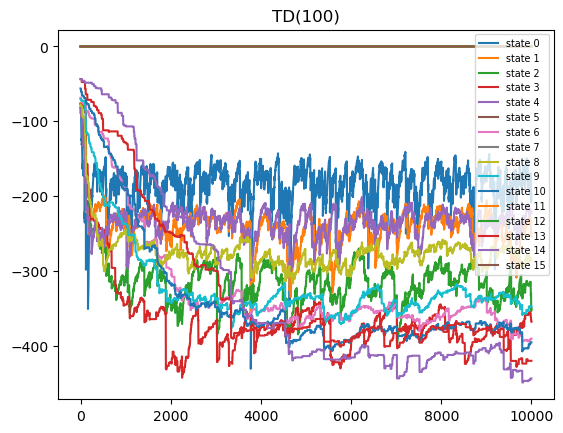

array([[ -83.313,  -76.011,  -76.692, ...,  -43.549,  -43.654,    0.   ],
       [ -83.46 ,  -76.011,  -76.692, ...,  -43.549,  -43.654,    0.   ],
       [ -83.957,  -76.011,  -76.692, ...,  -43.549,  -43.654,    0.   ],
       ...,
       [-200.607, -252.6  , -351.808, ..., -420.376, -444.013,    0.   ],
       [-198.753, -251.632, -350.325, ..., -420.376, -444.013,    0.   ],
       [-196.93 , -251.632, -350.325, ..., -420.376, -444.013,    0.   ]])

In [59]:
td_num = 100
for i in range(EPISODE_NUM):
    run_td(max_steps=10000, env=env, epsilon=1.0, td_num=td_num)
    V_history[i] = V.copy()
       
print_array_and_map_in_2D(MAPS[MAP], V_history[-1])        
show_V_history(V_history, f"TD({td_num})")

V_history

Notes: 
- TD(100) doesn't look like the every visit method at all. 
    - Make sure max_steps is high enough. Because by that time, the episode has finished!
- My implementation doesn't seem right ....

╒═════════════╤════════════╤════════════╤═══════════╕
│ S -180.33   │ F -228.9   │ F -283.7   │ H 0.0     │
╞═════════════╪════════════╪════════════╪═══════════╡
│ F -238.74   │ H 0.0      │ F -332.47  │ F -386.32 │
├─────────────┼────────────┼────────────┼───────────┤
│ F -317.55   │ F -341.73  │ F -357.83  │ F -408.91 │
├─────────────┼────────────┼────────────┼───────────┤
│ F -371.53   │ H 0.0      │ H 0.0      │ G 0.0     │
╘═════════════╧════════════╧════════════╧═══════════╛


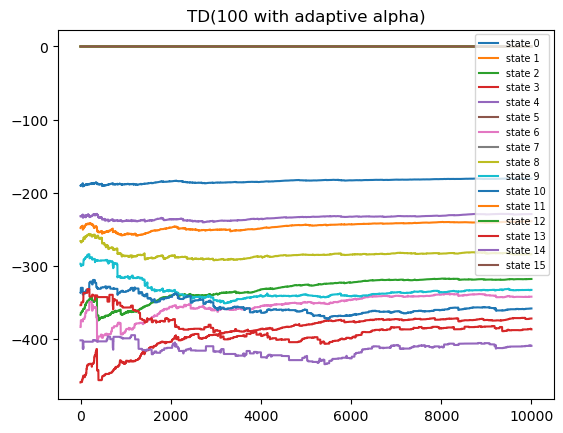

array([[-190.045, -247.812, -366.371, ..., -353.364, -401.391,    0.   ],
       [-189.914, -247.779, -366.054, ..., -353.364, -401.391,    0.   ],
       [-189.816, -247.693, -365.873, ..., -353.364, -401.391,    0.   ],
       ...,
       [-180.341, -238.748, -317.581, ..., -386.321, -408.909,    0.   ],
       [-180.336, -238.748, -317.581, ..., -386.321, -408.909,    0.   ],
       [-180.334, -238.736, -317.553, ..., -386.321, -408.909,    0.   ]])

In [70]:
td_num = 100
EPISODE_NUM = 10000
for i in range(EPISODE_NUM):
    run_td(max_steps=10000, env=env, epsilon=1.0, td_num=td_num, adaptive_alpha=True)
    V_history[i] = V.copy()
       
print_array_and_map_in_2D(MAPS[MAP], V_history[-1])        
show_V_history(V_history, f"TD({td_num} with adaptive alpha)")

V_history


## TD Control
Here, we still use the frozen lake environment


### SARSA

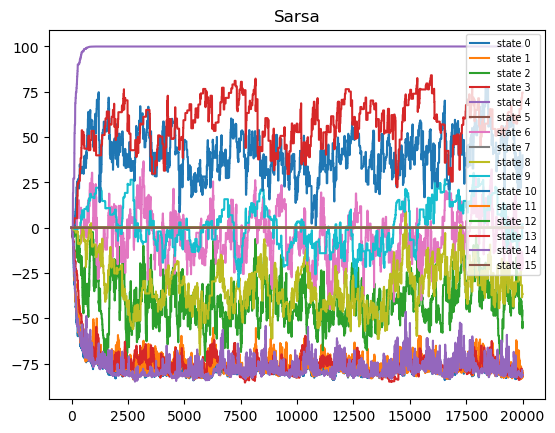

=========================Single Run========================
state: 0, action: 3, reward: 0.0
state: 0, action: 3, reward: 0.0
state: 0, action: 3, reward: 0.0
state: 0, action: 3, reward: 0.0
state: 0, action: 3, reward: 0.0
state: 0, action: 3, reward: 0.0
state: 0, action: 3, reward: 0.0
state: 0, action: 3, reward: 0.0
state: 0, action: 3, reward: 0.0
state: 0, action: 3, reward: 0.0
state: 0, action: 3, reward: 0.0
state: 0, action: 3, reward: 0.0
state: 0, action: 3, reward: 0.0
state: 0, action: 3, reward: 0.0
state: 0, action: 3, reward: 0.0
state: 0, action: 3, reward: 0.0
state: 0, action: 3, reward: 0.0
state: 0, action: 3, reward: 0.0
state: 0, action: 3, reward: 0.0
state: 0, action: 3, reward: 0.0
state: 0, action: 3, reward: 0.0
state: 0, action: 3, reward: 0.0
state: 0, action: 3, reward: 0.0
state: 0, action: 3, reward: 0.0
state: 0, action: 3, reward: 0.0
state: 0, action: 3, reward: 0.0
state: 0, action: 3, reward: 0.0
state: 0, action: 3, reward: 0.0
state: 0, action

In [35]:
def generate_replay_buffer(env, desired_length, replay_buffer, policy, start_state, epsilon):
    # Function that fills in replay buffer
    # replay_buffer = next state, a,r,done
    if len(replay_buffer) < desired_length:
        a = epsilon_greedy_policy(policy, start_state, env.nA, epsilon)
        buffer_start_state, r, done, _ = env.step(a)
        replay_buffer.append((buffer_start_state, a, r, done))
        env.render(state_output_file)
        next_start_state = replay_buffer[-1][0]
        generate_replay_buffer(env, desired_length, replay_buffer, policy, next_start_state, epsilon)

EPISODE_NUM = 20000
# EPISODE_NUM = 1
GAMMA = 0.99
EPSILON = 0.6
ALPHA = 0.1
MAP = "4x4"
# RUN_NUM = 10
RUNS_NUM = 1
env = FrozenLakeEnv(map_name=MAP, is_slippery=False) 
# env = FrozenLakeEnv(map_name=MAP, is_slippery=True) 
state_output_file = "sarsa_frozen_lake.tmp"
# TODO: generate random seeds for each run
V_history = deque()
for r in range(RUNS_NUM):
    policy = np.zeros(env.nS, dtype=int)  
    # Q_sa = np.random.uniform(0, 10.0, (env.nS, env.nA))
    Q_sa = np.zeros((env.nS, env.nA))
    for e in range(EPISODE_NUM):
        replay_buffer = deque()
        current_state = env.reset()
        done = False
        while not done:
            generate_replay_buffer(env, 2, replay_buffer, policy, current_state, EPSILON)
            next_state, a, r, done = replay_buffer.popleft()
            _, next_a, _, _ = replay_buffer[0]

            Q_sa[current_state][a] += ALPHA * (r + GAMMA * Q_sa[next_state][next_a] - Q_sa[current_state][a])
            # update pi
            policy[current_state] = int(np.argmax(Q_sa[current_state]))
            #TODO Remember to remove
            # print(f'r: {r}, e: {e}, Rico: {current_state}, Q_sa[current_state]: {Q_sa[current_state]}, policy: {policy[current_state]}')
            current_state = next_state
        update_v_history(V_history, Q_sa)

show_V_history(V_history, f"Sarsa")

# policy = np.asarray(policy, dtype=int)
render_single(env, policy, state_output_file, max_steps=100)
#TODO Remember to remove
print(f'Rico: policy: {policy}, Q_sa: {Q_sa}')



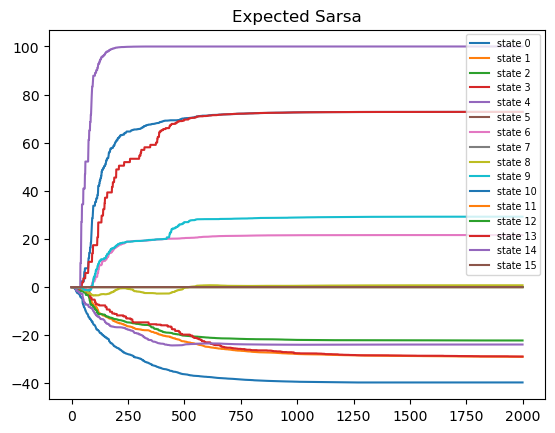

=========================Single Run========================
state: 0, action: 1, reward: 0.0
state: 4, action: 1, reward: 0.0
state: 8, action: 2, reward: 0.0
state: 9, action: 1, reward: 0.0
state: 13, action: 2, reward: 0.0
Episode reward: 100.000000
Rico: policy: [1 2 1 0 1 0 1 0 2 1 1 0 0 2 2 0], Q_sa: [[ -39.76   -39.642  -42.885  -39.757]
 [ -39.747 -100.     -28.988  -42.824]
 [ -42.847  -22.202  -42.147  -28.914]
 [ -28.874  -99.536  -40.101  -39.491]
 [ -39.641  -23.879 -100.     -39.756]
 [   0.       0.       0.       0.   ]
 [-100.      21.617  -99.999  -28.787]
 [   0.       0.       0.       0.   ]
 [ -23.879 -100.       0.742  -39.641]
 [ -23.88    29.252   21.617 -100.   ]
 [   0.734   72.817 -100.     -22.177]
 [   0.       0.       0.       0.   ]
 [   0.       0.       0.       0.   ]
 [ -99.999   29.247   72.817    0.74 ]
 [  29.251   72.817  100.      21.617]
 [   0.       0.       0.       0.   ]]


In [32]:
def get_expectation(Q_sa, next_state, policy, EPSILON, env):
    expectation = 0.0
    default_prob = EPSILON/env.nA
    for a, q in enumerate(Q_sa[next_state]):
        if policy[next_state] == a:
            prob = 1.0 - EPSILON + default_prob
        else:
            prob = default_prob
        expectation += prob * q
    return expectation

EPISODE_NUM = 2000
GAMMA = 0.99
EPSILON = 0.6
ALPHA = 0.1
MAP = "4x4"
RUNS_NUM = 1
env = FrozenLakeEnv(map_name=MAP, is_slippery=False) 
state_output_file = "expected_sarsa_frozen_lake.tmp"
V_history = deque()
for run_i in range(RUNS_NUM):
    policy = np.zeros(env.nS, dtype=int)  
    Q_sa = np.zeros((env.nS, env.nA))
    for e in range(EPISODE_NUM):
        current_state = env.reset()
        done = False
        while not done:
            a = epsilon_greedy_policy(policy, current_state, env.nA, EPSILON)
            next_state, r, done, _ = env.step(a)
            expectation = get_expectation(Q_sa, next_state, policy, EPSILON, env)
            Q_sa[current_state][a] += ALPHA * (r + GAMMA * expectation - Q_sa[current_state][a])
            # update pi
            policy[current_state] = int(np.argmax(Q_sa[current_state]))
            current_state = next_state
        update_v_history(V_history, Q_sa)

show_V_history(V_history, f"Expected Sarsa")
render_single(env, policy, state_output_file, max_steps=100)
print(f'Rico: policy: {policy}, Q_sa: {Q_sa}')




Note: Expected SARSA converges faster, whereas regular SARSA may not converge

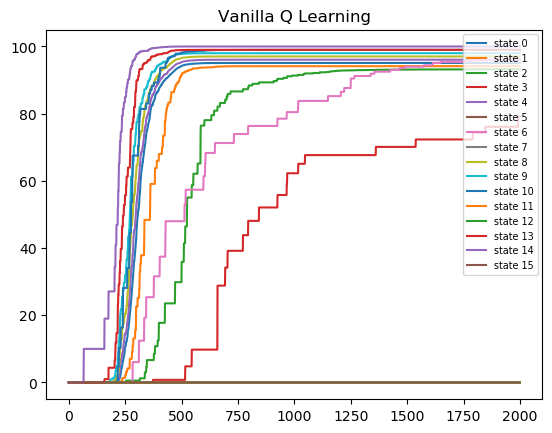

=========================Single Run========================
state: 0, action: 1, reward: 0.0
state: 4, action: 1, reward: 0.0
state: 8, action: 2, reward: 0.0
state: 9, action: 1, reward: 0.0
state: 13, action: 2, reward: 0.0
Episode reward: 100.000000
Rico: policy: [1 0 0 0 1 0 1 0 2 1 1 0 0 2 2 0], Q_sa: [[  94.148   95.099   93.207   94.148]
 [  94.148 -100.      92.234   93.204]
 [  93.2     76.618   61.25    77.824]
 [  79.18   -65.132   10.35    31.18 ]
 [  95.099   96.06  -100.      94.148]
 [   0.       0.       0.       0.   ]
 [ -68.619   96.455  -87.842   58.426]
 [   0.       0.       0.       0.   ]
 [  96.06  -100.      97.03    95.099]
 [  96.06    98.01    98.01  -100.   ]
 [  96.703   99.     -99.967   91.574]
 [   0.       0.       0.       0.   ]
 [   0.       0.       0.       0.   ]
 [-100.      98.01    99.      97.03 ]
 [  98.01    99.     100.      98.01 ]
 [   0.       0.       0.       0.   ]]


In [39]:
def get_max_action_Q(policy, next_state, Q_sa):
    a_next = policy[next_state]
    return Q_sa[next_state][a_next]

EPISODE_NUM = 2000
GAMMA = 0.99
EPSILON = 0.6
ALPHA = 0.1
MAP = "4x4"
# RUN_NUM = 10
RUNS_NUM = 1
env = FrozenLakeEnv(map_name=MAP, is_slippery=False) 
state_output_file = "expected_sarsa_frozen_lake.tmp"
V_history = deque()
for run_i in range(RUNS_NUM):
    policy = np.zeros(env.nS, dtype=int)  
    Q_sa = np.zeros((env.nS, env.nA))
    for e in range(EPISODE_NUM):
        current_state = env.reset()
        done = False
        while not done:
            a = epsilon_greedy_policy(policy, current_state, env.nA, EPSILON)
            next_state, r, done, _ = env.step(a)
            max_action_q = get_max_action_Q(policy, next_state, Q_sa)
            Q_sa[current_state][a] += ALPHA * (r + GAMMA * max_action_q - Q_sa[current_state][a])
            # update pi
            policy[current_state] = int(np.argmax(Q_sa[current_state]))
            current_state = next_state
        update_v_history(V_history, Q_sa)

show_V_history(V_history, f"Vanilla Q Learning")
render_single(env, policy, state_output_file, max_steps=100)
print(f'Rico: policy: {policy}, Q_sa: {Q_sa}')





Note: see Q learning values are higher than that of expected SARSA. That's because it updates its Q values optimistically (by updating with max Q value for the next action)

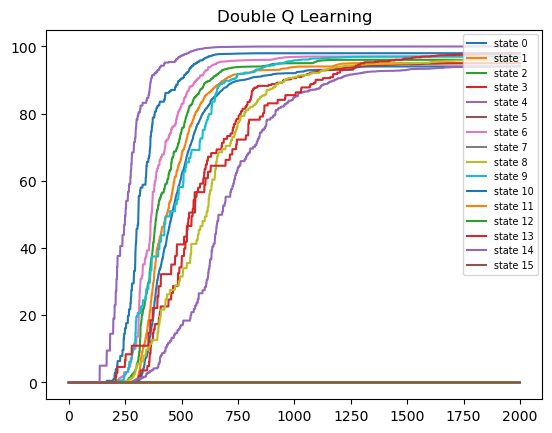

=========================Single Run========================
state: 0, action: 2, reward: 0.0
state: 1, action: 2, reward: 0.0
state: 2, action: 1, reward: 0.0
state: 6, action: 1, reward: 0.0
state: 10, action: 1, reward: 0.0
Episode reward: 100.000000
Rico: policy: [2 2 1 0 1 0 1 0 2 2 1 0 0 2 2 0], Q_sa: [[  94.148   95.099   93.207   94.148]
 [  94.148 -100.      92.234   93.204]
 [  93.2     76.618   61.25    77.824]
 [  79.18   -65.132   10.35    31.18 ]
 [  95.099   96.06  -100.      94.148]
 [   0.       0.       0.       0.   ]
 [ -68.619   96.455  -87.842   58.426]
 [   0.       0.       0.       0.   ]
 [  96.06  -100.      97.03    95.099]
 [  96.06    98.01    98.01  -100.   ]
 [  96.703   99.     -99.967   91.574]
 [   0.       0.       0.       0.   ]
 [   0.       0.       0.       0.   ]
 [-100.      98.01    99.      97.03 ]
 [  98.01    99.     100.      98.01 ]
 [   0.       0.       0.       0.   ]]


In [48]:
# Double Q Learning
def update_Q(Q_sa, current_state, next_state, r, a):
    max_q_next = int(max(Q_sa[next_state]))
    Q_sa[current_state][a] += ALPHA * (r + GAMMA * max_q_next - Q_sa[current_state][a])

EPISODE_NUM = 2000
GAMMA = 0.99
EPSILON = 0.6
ALPHA = 0.1
MAP = "4x4"
# RUN_NUM = 10
RUNS_NUM = 1
env = FrozenLakeEnv(map_name=MAP, is_slippery=False) 
state_output_file = "expected_sarsa_frozen_lake.tmp"
V_history = deque()
for run_i in range(RUNS_NUM):
    policy = np.zeros(env.nS, dtype=int)
    Q_sa1 = np.zeros((env.nS, env.nA))
    Q_sa2 = np.zeros((env.nS, env.nA))
    for e in range(EPISODE_NUM):
        current_state = env.reset()
        done = False
        while not done:
            # update pi
            policy[current_state] = int(np.argmax(Q_sa1[current_state] + Q_sa2[current_state]))
            a = epsilon_greedy_policy(policy, current_state, env.nA, EPSILON)
            next_state, r, done, _ = env.step(a)
            if np.random.uniform() < 0.5:
                update_Q(Q_sa1, current_state, next_state, r, a)
            else:
                update_Q(Q_sa2, current_state, next_state, r, a)
            current_state = next_state
        update_v_history(V_history, 0.5*(Q_sa1+Q_sa2))

show_V_history(V_history, f"Double Q Learning")
render_single(env, policy, state_output_file, max_steps=100)
print(f'Rico: policy: {policy}, Q_sa: {Q_sa}')

